# <font color='#002726'> Data Science em Produção </font>
    
=-=- ROSSMANN - STORE SALES PREDICTION -=-=

# <font color='#3F0094'> 0. Imports </font>

In [1]:
# general use
import numpy as np
import pandas as pd

# helper function
import inflection

# feature engineering and data analysis
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display               import Image
from datetime                      import datetime, timedelta
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

## <font color='#200CF'> 0.1. Helper Functions </font>

In [2]:
# Notebook Setups

sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette('Set2')

# Functions

def snakecase(list_of_names):
    """Returns a list of names in snake case, which refers to the style of  
    writing in which each space is replaced by an underscore (_) character."""
    
    new_list = list(map(inflection.underscore, list_of_names))
    return new_list



## <font color='#200CF'> 0.2. Loading Data </font>

In [3]:
# loading historical data - including Sales
df_sales_raw = pd.read_csv('../raw_data/train.csv', low_memory=False)

# loading information about the stores
df_store_raw = pd.read_csv('../raw_data/store.csv', low_memory=False)

# merging dataframes
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

### <font color='#F37126'> Data Fields </font>

**Most of the fields are self-explanatory. The following are descriptions for those that aren't.**

- **Id** - an Id that represents a (Store, Date) duple within the test set;
- **Store** - a unique Id for each store;
- **Sales** - the turnover for any given day (this is what you are predicting);
- **Customers** - the number of customers on a given day;
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open;
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None;
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools;
- **StoreType** - differentiates between 4 different store models: a, b, c, d;
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended;
- **CompetitionDistance** - distance in meters to the nearest competitor store;
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened;
- **Promo** - indicates whether a store is running a promo on that day;
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating;
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2;
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

# <font color='#3F0094'> 1. Descriptive Data Analysis </font>

## <font color='#200CF'> 1.0. Dataframe in Progress Backup </font>

In [4]:
df1 = df_raw.copy()

## <font color='#200CF'> 1.1. Column Renaming </font>

In [5]:
# renaming df1 column names
df1.columns = snakecase(df1.columns)


## <font color='#200CF'> 1.2. Data Dimension </font>

In [6]:
print(f'Store Dataframe - Number of Rows: {df1.shape[0]}. \nStore Dataframe - Number of Columns: {df1.shape[1]}.')

Store Dataframe - Number of Rows: 1017209. 
Store Dataframe - Number of Columns: 18.


## <font color='#200CF'> 1.3. Data Types </font>

In [7]:
# dataframe data types
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
# setting date column as datetime type
df1['date'] = pd.to_datetime(df1['date'])


## <font color='#200CF'> 1.4. NA Check </font>

In [9]:
# checking NA - All NA values came from store.csv
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [10]:
# checking NA using info()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## <font color='#200CF'> 1.5. Filling in Missing/Null Values </font>

**Number of NA Values**

    competition_distance              2642

    competition_open_since_month    323348
    competition_open_since_year     323348

    promo2_since_week               508031
    promo2_since_year               508031
    promo_interval                  508031

In [11]:
# competition_distance

# maximun distance x 2
max_dist_x_2 = df1['competition_distance'].max() * 2

# assuming competitors are twice as far away as the greatest distance found
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_dist_x_2 if np.isnan(x) else x)


# competition_open_since_year

# frequency per year of existing competition_open_since_year data
frequency = df1['competition_open_since_year'].value_counts(
                                                normalize=True).reset_index().rename(
                                                columns={'index': 'year', 
                                                         'competition_open_since_year': 'percent'})

# True/False missing/Null Series
missing = df1['competition_open_since_year'].isna()

# Using Numpy's random.choice to fill out missing data based on the frequency of existing info
df1.loc[missing,'competition_open_since_year'] = np.random.choice(frequency.year, 
                                                                  size=len(df1[missing]), 
                                                                  p=frequency.percent)


# competition_open_since_month

# frequency per month of existing competition_open_since_month data
frequency = df1['competition_open_since_month'].value_counts(
                                                normalize=True).reset_index().rename(
                                                columns={'index': 'month', 
                                                         'competition_open_since_month': 'percent'})

# True/False missing/Null Series
missing = df1['competition_open_since_month'].isna()

# Using Numpy's random.choice to fill out missing data based on the frequency of existing info
df1.loc[missing,'competition_open_since_month'] = np.random.choice(frequency.month, 
                                                                   size=len(df1[missing]), 
                                                                   p=frequency.percent)


# promo2_since_week AND promo2_since_year

# the same date of sale will be used as a reference to fill in the NA values
# then a new timedelta column will be created (promo2_duration)

#promo2_since_week
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval

# filling in NA with 'none'
df1['promo_interval'].fillna(value='none', inplace=True)
# creating a column with current month
df1['curr_month'] = df1['date'].dt.strftime('%b')
# creating a column to indicate whether promo2 is active
df1['promo2_active'] = df1.apply(lambda x: 1 if ((
    x['curr_month'] in x['promo_interval'].split(',')) and (
    x['date'] >= datetime.fromisocalendar(int(x['promo2_since_year']), int(x['promo2_since_week']), 1))) else 0, axis=1)

## <font color='#200CF'> 1.6. Changing Data Types </font>

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
curr_month                              object
promo2_active                            int64
dtype: object

In [13]:
# Changing DTypes from float to integer

df1['competition_distance'] = df1['competition_distance'].astype(int)
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## <font color='#200CF'> 1.7. Descriptive Statistics </font>

### <font color='#2365FF'> 1.7.0. Numeric vs Categorical - Attributes Split </font>

In [14]:
# dataframe - numeric attributes
df_numeric = df1.select_dtypes(include=['int64', 'float64'])

# dataframe - categorical attributes
df_categorical = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### <font color='#2365FF'> 1.7.1. Numeric Attributes </font>

In [15]:
# using DF describe() method
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5810.044888,10715.012901,20.0,710.0,2330.0,6910.0,151720.0
competition_open_since_month,1017209.0,7.221293,3.213629,1.0,4.0,8.0,10.0,12.0
competition_open_since_year,1017209.0,2008.693831,5.960750,1900.0,2006.0,2010.0,2013.0,2015.0


In [16]:
# central tendency metrics - mean, median
ct_mean = df_numeric.apply(np.mean)
ct_median = df_numeric.apply(np.median)

# dispersion metrics - std, min, max, range, skew, kurtosis
d_std = df_numeric.apply(np.std)
d_min = df_numeric.apply(min)
d_max = df_numeric.apply(max)
d_range = df_numeric.apply(lambda x: x.max() - x.min())
d_skew = df_numeric.apply(lambda x: x.skew())
d_kurtosis = df_numeric.apply(lambda x: x.kurtosis())

metrics = pd.DataFrame({
    'min': d_min, 'max': d_max, 'range': d_range, 'mean': ct_mean, 
    'median': ct_median, 'std': d_std, 'skew': d_skew, 'kurtosis': d_kurtosis
})
metrics

,min,max,range,mean,median,std,skew,kurtosis
store,1,1115,1114,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1,7,6,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0,41551,41551,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0,7388,7388,633.145946,609.0,464.411506,1.598650,7.091773
open,0,1,1,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0,1,1,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0,1,1,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20,151720,151700,5810.044888,2330.0,10715.007635,7.593832,90.447876
competition_open_since_month,1,12,11,7.221293,8.0,3.213628,-0.168935,-1.249706
competition_open_since_year,1900,2015,115,2008.693831,2010.0,5.960747,-7.474744,121.241211


**competition_distance**
 - Skew: highly skewed data, high positive value means that the right-hand tail is much longer than the left-hand tail.
 - Kurtosis: increases as the tails become heavier, the high positive value indicates a very peaked curve.

**competition_open_since_year**
 - Skew: highly skewed data, high negative value means that the left-hand tail is longer than the right-hand tail.
 - Kurtosis: increases as the tails become heavier, the high positive value indicates a very peaked curve.

**sales**
 - Skewness is close to zero, indicating that the data is not too skewed

### <font color='#2365FF'> 1.7.2. Categorical Attributes </font>

In [17]:
# verifying unique valuesfor each categorical attribute
df_categorical.apply(lambda x: len(x.unique()))

state_holiday      4
store_type         4
assortment         3
promo_interval     4
curr_month        12
dtype: int64

**BOXPLOT OF CATEGORICAL ATTRIBUTES**

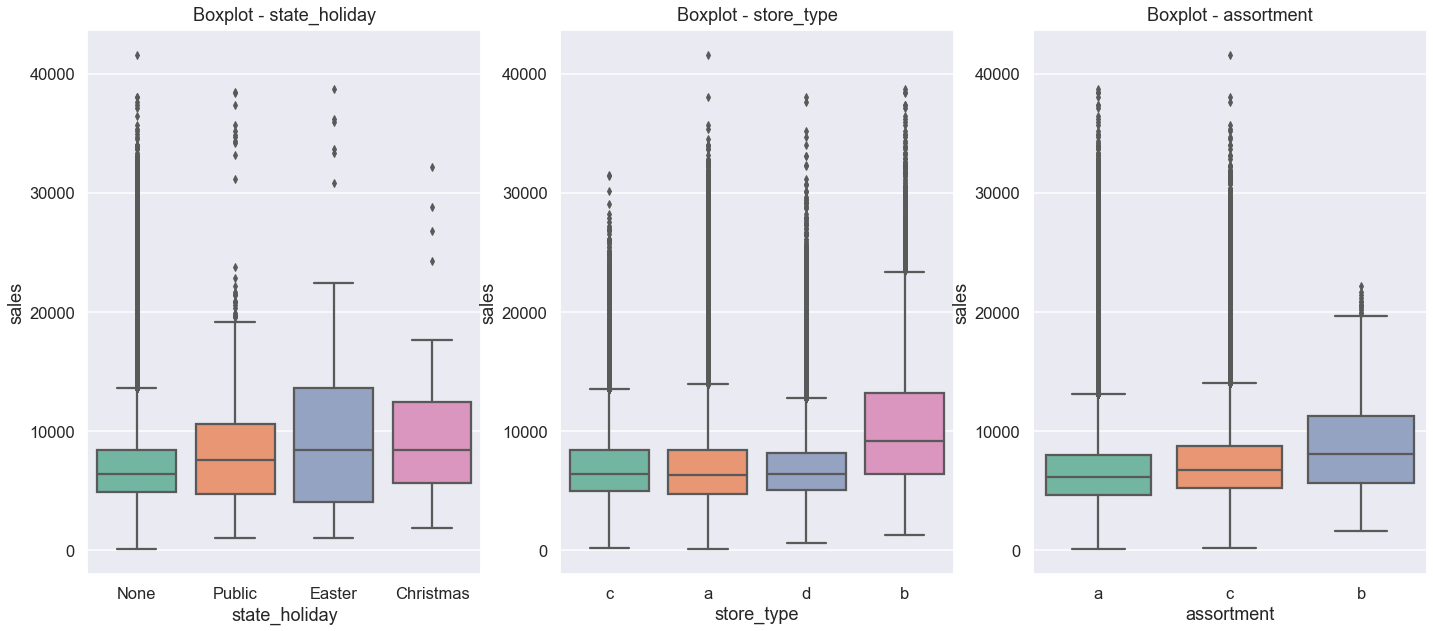

In [18]:
# Boxplot - Categorical Attributes

# not considering when: sales = 0 
aux = df1[df1['sales'] > 0]

plt.figure(figsize=(24,10))

plt.subplot(1, 3, 1)
ax1 = sns.boxplot(x='state_holiday', y='sales', data=aux)
ax1.set_title('Boxplot - state_holiday', fontsize=18, pad=10)
ax1.set_xticklabels(labels=['None', 'Public', 'Easter', 'Christmas'])

plt.subplot(1, 3, 2)
ax2 = sns.boxplot(x='store_type', y='sales', data=aux)
ax2.set_title('Boxplot - store_type', fontsize=18, pad=10)

plt.subplot(1, 3, 3)
ax3 = sns.boxplot(x='assortment', y='sales', data=aux)
ax3.set_title('Boxplot - assortment', fontsize=18, pad=10)

plt.show()

**BOXPLOT OF BINARY CATEGORICAL ATTRIBUTES**

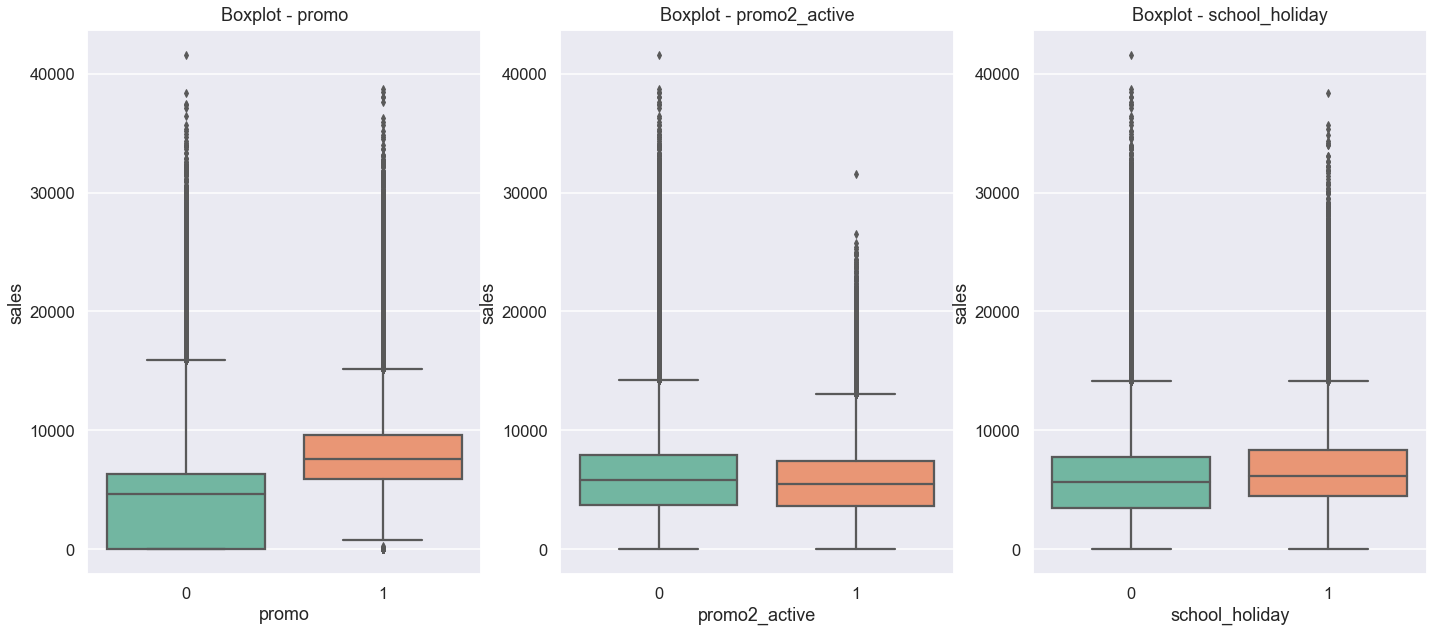

In [19]:
# Boxplot - Binary ategorical Attributes

plt.figure(figsize=(24,10))

plt.subplot(1, 3, 1)
ax1 = sns.boxplot(x='promo', y='sales', data=df1)
ax1.set_title('Boxplot - promo', fontsize=18, pad=10)

plt.subplot(1, 3, 2)
ax2 = sns.boxplot(x='promo2_active', y='sales', data=df1)
ax2.set_title('Boxplot - promo2_active', fontsize=18, pad=10)

plt.subplot(1, 3, 3)
ax3 = sns.boxplot(x='school_holiday', y='sales', data=df1)
ax3.set_title('Boxplot - school_holiday', fontsize=18, pad=10)

plt.show()

# <font color='#3F0094'> 2. Feature Egineering </font>

## <font color='#200CF'> 2.0. Dataframe in Progress Backup </font>

In [20]:
df2 = df1.copy()

## <font color='#200CF'> 2.1. Mind Map </font>

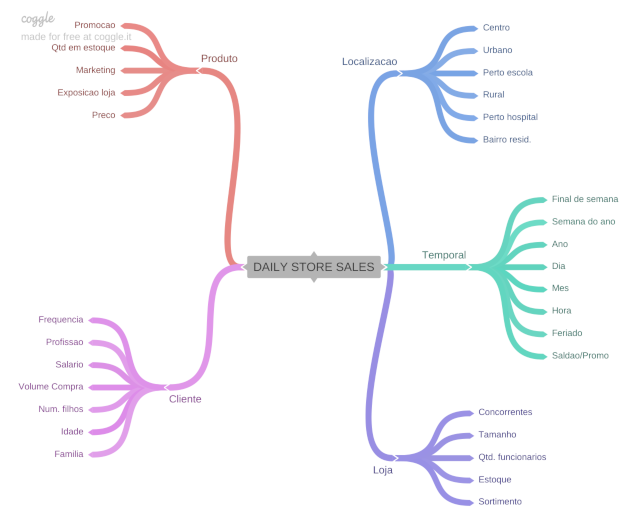

In [21]:
# made on coggle.it
Image('../img/mind_map01.png')

## <font color='#200CF'> 2.2. Hypothesis </font>

**Based on Descriptive Statistics and on Mind Map**

### <font color='#2365FF'> 2.1.1. Store-related Hypothesis </font>

**a1.** The median sales of stores with the largest assortment should be the highest.

**a2.** The average value of sales for a specific type of store is higher than the average value for other types (store types: a, b, c, d).

**a3.** The average sales value of stores with competitors whose distance is less than 1000 meters is lower than the average value of other stores.

**a4.** The average sales values of stores whose competitors opened less than 18 months ago are lower than the average values of other stores.

### <font color='#2365FF'> 2.1.2. Product-related Hypothesis </font>

**b1.** The median sales value of stores should be greater when running a promo (promo) than when not running a promo.

**b2.** The median sales value of stores with continuing and consecutive promotion (promo2) should be greater than those that do not have extended promotion.

**b3.** The median sales value of stores on sale (promo2) for a longer period of time should be higher than stores on sale for a shorter period of time.

### <font color='#2365FF'> 2.1.3. Time-related Hypothesis </font>

**c1.** The average ticket per customer should be lower during holiday periods.

**c2.** Stores affected by the closure of public schools on school holidays should sell less, on average.

**c3.** The revenue in the second half should be higher than in the first half.

**c4.** Average sales during the winter should be higher than during the rest of the year.

**c5.** Average sales during the weekend should be lower than during the rest of the week.

## <font color='#200CF'> 2.3. Feature Engineering </font>

In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# competition_months_old
# calculating the competition period, extracting the days and dividing by 30 to get the period in months
df2['competition_months_old'] = df2.apply(lambda x: (
    x['date'] - datetime(year=x['competition_open_since_year'], 
                         month=x['competition_open_since_month'], 
                         day=1)).days / 30, axis=1).astype(int)

# promo2_months_old
# calculation method: zero(0) if promo2_active is zero(0) else (actual_date - promo2_starting_date) >> timedelta format 
# >> then use .days and divide by 30 to extract the number of months >> as integer
df2['promo2_months_old'] = df2.apply(lambda x: 0 if x['promo2_active'] == 0 else (
    x['date'] - datetime.fromisocalendar(x['promo2_since_year'], 
                                         x['promo2_since_week'], 
                                         1)).days / 30, axis=1).astype(int)

# assortment
df2['assortment'] = df2['assortment'].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})

# state_holiday
df2['state_holiday'] = df2['state_holiday'].map({'0': 'none', 'a': 'public', 'b': 'easter', 'c': 'christmas'})

# =-=-=-=- WARNING: EDA USE ONLY -=-=-=-=
# customer_avg_ticket
df2['customers_avg_ticket'] = (df2['sales'] / df2['customers'])
df2['customers_avg_ticket'].fillna(value=0, inplace=True)

# <font color='#3F0094'> 3. Feature Filtering </font>

## <font color='#200CF'> 3.0. Dataframe in Progress Backup </font>

In [23]:
df3 = df2.copy()

## <font color='#200CF'> 3.1. Filtering Rows </font>

In [24]:
# eliminating all records where stores are closed and sales are zero
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## <font color='#200CF'> 3.2. Filtering Columns </font>

**customers:** the number of customers will not be available to be used in the model prediction, as it is an unknown and variable value in the future.

**open:** column has record 1 only.

**promo_interval, curr_month:** auxiliary columns already used in the feature engineering step.

**Important Warning:** column **customers_avg_ticket** will only be used during EDA and will be discarded later.

In [25]:
# list of columns to be droped
cols_drop = ['customers', 'open', 'promo_interval', 'curr_month']
df3.drop(cols_drop, axis=1, inplace=True)

In [26]:
df3.shape

(844338, 23)

# <font color='#3F0094'> 4. Exploratory Data Analysis </font>

## <font color='#200CF'> 4.0. Dataframe in Progress Backup </font>

In [27]:
df4 = df3.copy()

# dataframe - numeric attributes - binary attributes droped
df_numeric = df4.select_dtypes(include=['int64', 'float64']).drop(['promo','promo2','promo2_active', 'school_holiday'], axis=1)

# dataframe - categorical attributes
df_categorical = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
df_bin_cat = pd.concat([df4['promo'], df4['promo2'], df4['promo2_active'], df4['school_holiday']],axis=1)


## <font color='#200CF'> 4.1. Univariate Analysis </font>

### <font color='#2365FF'> 4.1.1. Response Variable </font>

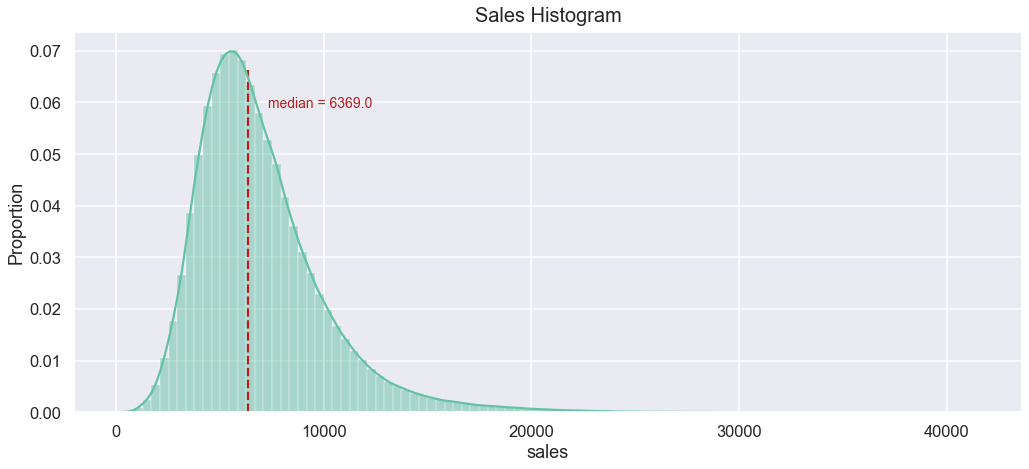

In [28]:
# sales histogram

ax = sns.histplot(data=df4, x='sales', stat='proportion', bins=100, kde=True)
y_min, y_max = ax.get_ylim()

ax.figure.set_size_inches(17, 7)
ax.set_title('Sales Histogram', fontsize=20, pad=10)

median = np.median(df_numeric['sales'])
ax.vlines(x=median, ymin=0, ymax=y_max*0.9, linestyles='dashed', label='median', colors='firebrick')
ax.annotate(f'median = {median}', xy=(median*1.15, y_max*0.8), fontsize=14, color='firebrick')

ax;

### <font color='#2365FF'> 4.1.2. Numeric Variable </font>

In [29]:
df_numeric.shape

(844338, 15)

**NUMERIC VARIABLES HISTOGRAMS**

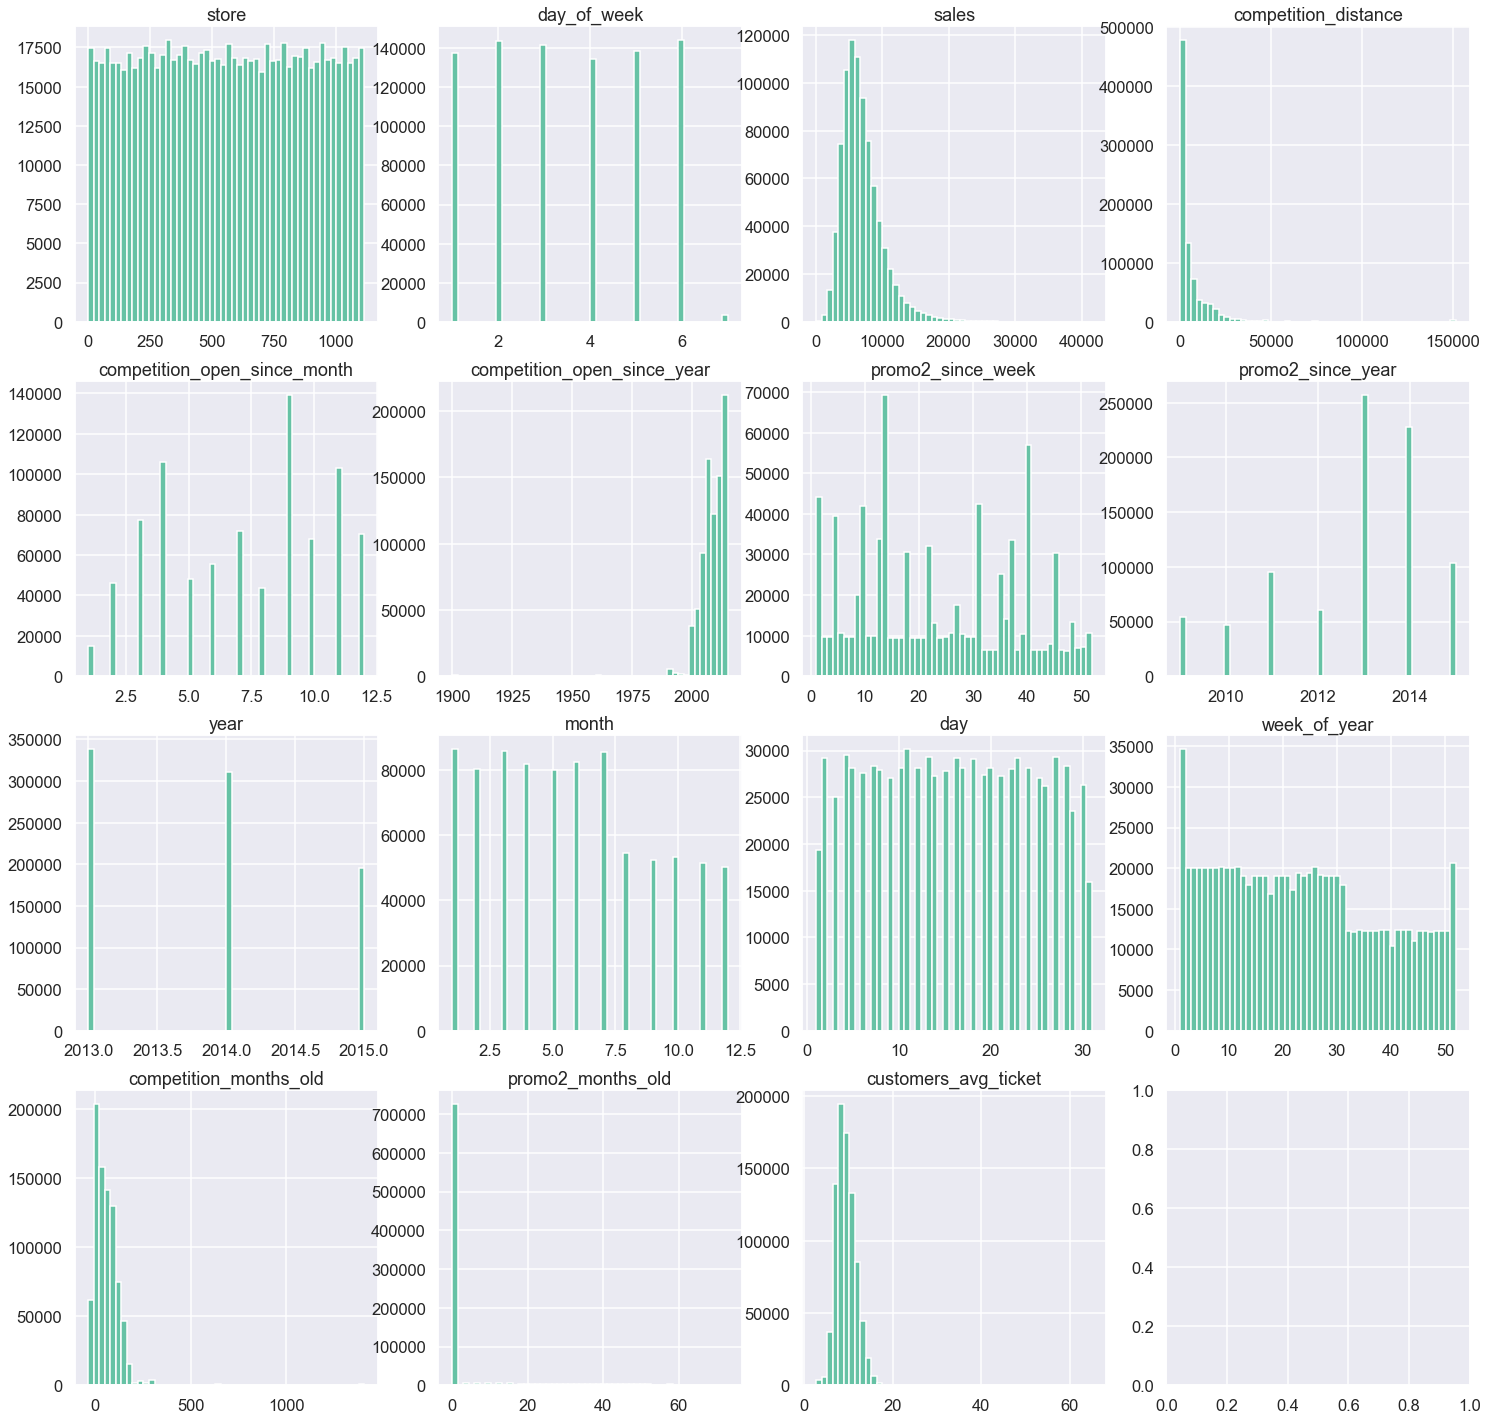

In [30]:
# ploting numeric attributes histograms

axes = list()
n_bins = 50
n=0

fig, axes = plt.subplots(nrows=4, ncols=4)
fig.set_size_inches(25, 25)

for i in range(4):
    for j in range(4):
        if n < 15:
            axes[i][j].hist(df_numeric.iloc[:, n], bins=n_bins)
            axes[i][j].set_title(df_numeric.iloc[:, n].name)
            n += 1

fig;

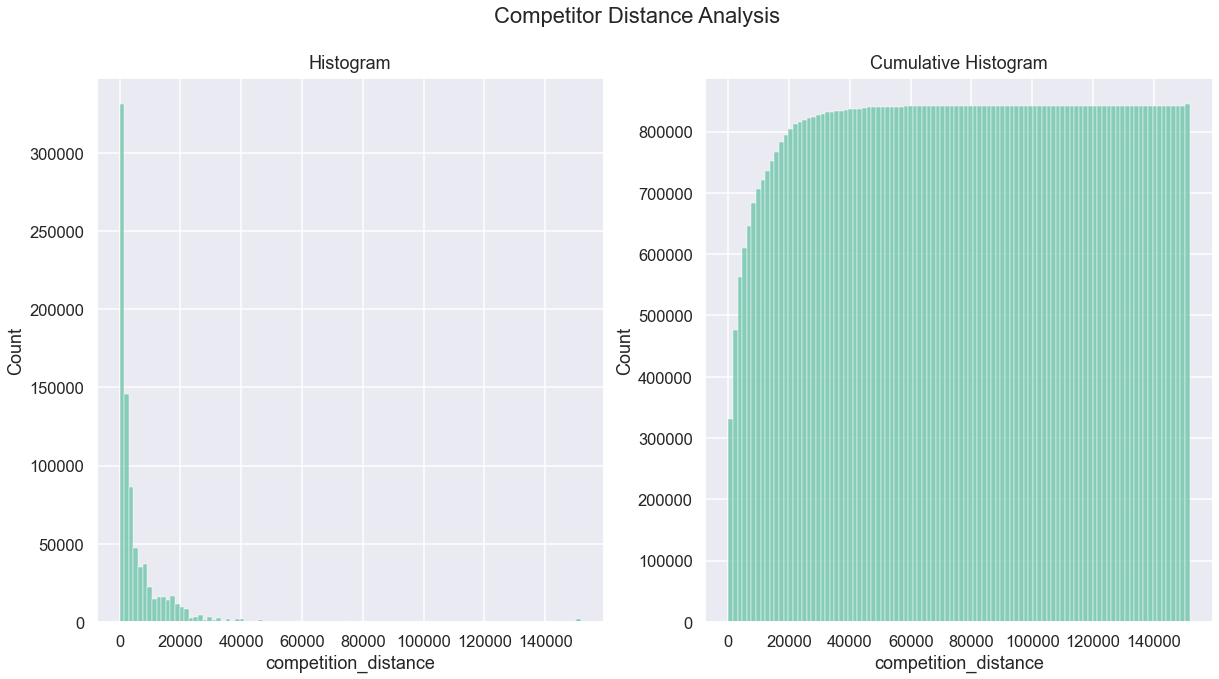

In [72]:
# competition_distance

plt.figure(figsize=(20,10))
plt.suptitle('Competitor Distance Analysis', fontsize=22)

plt.subplot(1, 2, 1)
ax1 = sns.histplot(data=df4, x='competition_distance', bins=100)
ax1.set_title("Histogram", fontsize=18, pad=10)

# cumulative counts as bins increase. 
plt.subplot(1, 2, 2)
ax2 = sns.histplot(data=df4, x='competition_distance', bins=100, cumulative=True)
ax2.set_title("Cumulative Histogram", fontsize=18, pad=10)

plt.show()

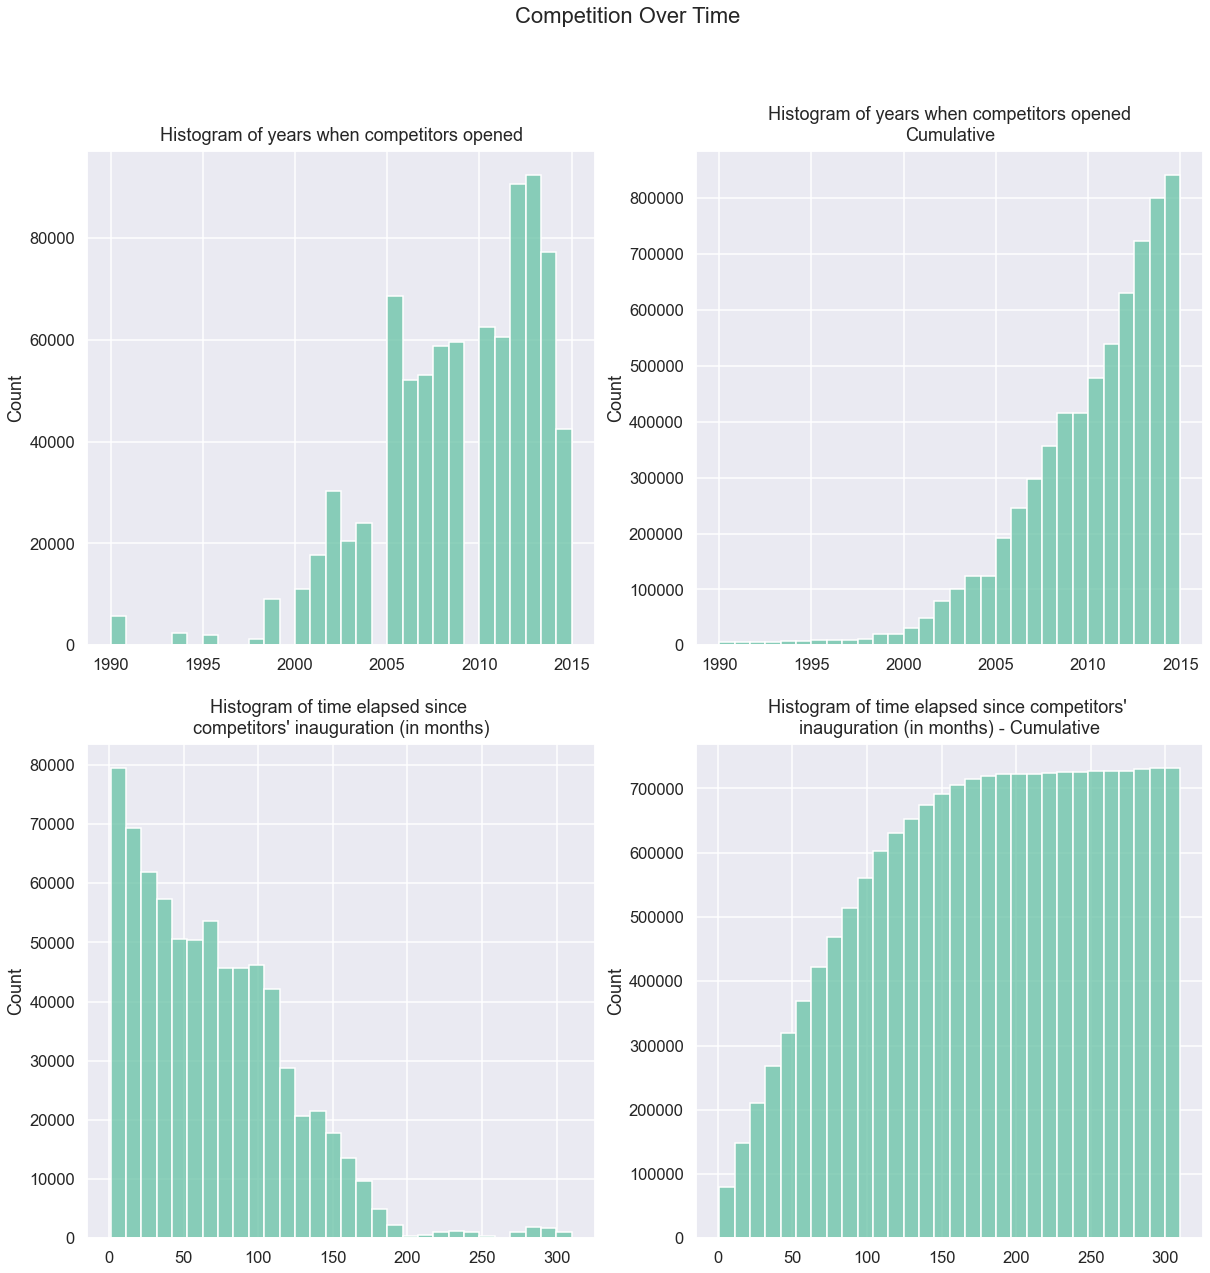

In [69]:
# competition_open_since_year -- competition_months_old

plt.figure(figsize=(20,20))
plt.suptitle('Competition Over Time', fontsize=22)

# analysing values between 1985 and present day (30 years)
plt.subplot(2, 2, 1)
ax1 = sns.histplot(data=df4.query("competition_open_since_year > 1985"), x='competition_open_since_year', bins=30)
ax1.set_title("Histogram of years when competitors opened", fontsize=18, pad=10)
ax1.set_xlabel("")

plt.subplot(2, 2, 2)
ax1 = sns.histplot(data=df4.query("competition_open_since_year > 1985"), x='competition_open_since_year', bins=30, cumulative=True)
ax1.set_title("Histogram of years when competitors opened\nCumulative", fontsize=18, pad=10)
ax1.set_xlabel("")

# analysing values greater than 0 and lower than 360 (30 years)
plt.subplot(2, 2, 3)
ax2 = sns.histplot(data=df4.query("competition_months_old > 0 and competition_months_old < 360"), x='competition_months_old', bins=30)
ax2.set_title("Histogram of time elapsed since \ncompetitors' inauguration (in months)", fontsize=18, pad=10)
ax2.set_xlabel("")

plt.subplot(2, 2, 4)
ax2 = sns.histplot(data=df4.query("competition_months_old > 0 and competition_months_old < 360"), x='competition_months_old', bins=30, cumulative=True)
ax2.set_title("Histogram of time elapsed since competitors' \ninauguration (in months) - Cumulative", fontsize=18, pad=10)
ax2.set_xlabel("")

plt.show()

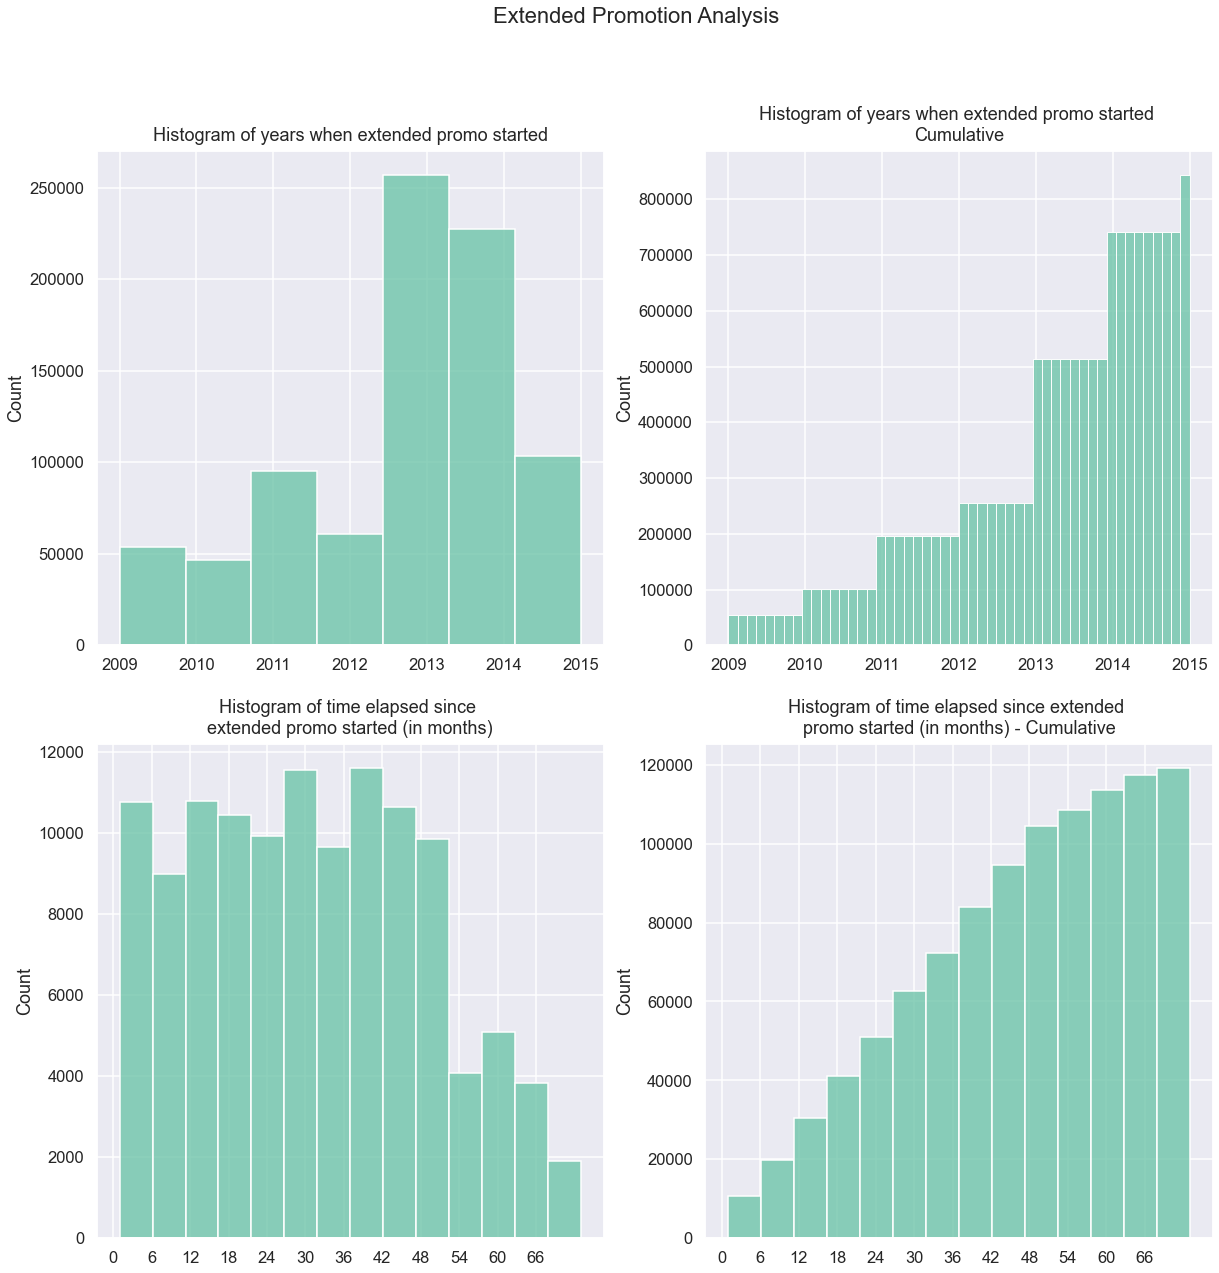

In [113]:
# promo2_since_year -- promo2_months_old

plt.figure(figsize=(20,20))
plt.suptitle('Extended Promotion Analysis', fontsize=22)

# 
plt.subplot(2, 2, 1)
ax1 = sns.histplot(data=df4, x='promo2_since_year', bins = 7)
ax1.set_title("Histogram of years when extended promo started", fontsize=18, pad=10)
ax1.set_xlabel("")

plt.subplot(2, 2, 2)
ax1 = sns.histplot(data=df4, x='promo2_since_year', bins=50, cumulative=True)
ax1.set_title("Histogram of years when extended promo started \nCumulative", fontsize=18, pad=10)
ax1.set_xlabel("")


# analysing values greater than zero
plt.subplot(2, 2, 3)
ax2 = sns.histplot(data=df4.query("promo2_months_old > 0"), x='promo2_months_old', bins=14)
ax2.set_title("Histogram of time elapsed since \nextended promo started (in months)", fontsize=18, pad=10)
ax2.set_xlabel("")
ax2.set_xticks(ticks=np.arange(0, 72, 6))

plt.subplot(2, 2, 4)
ax2 = sns.histplot(data=df4.query("promo2_months_old > 0"), x='promo2_months_old', bins=14, cumulative=True)
ax2.set_title("Histogram of time elapsed since extended \npromo started (in months) - Cumulative", fontsize=18, pad=10)
ax2.set_xlabel("")
ax2.set_xticks(ticks=np.arange(0, 72, 6))

plt.show()

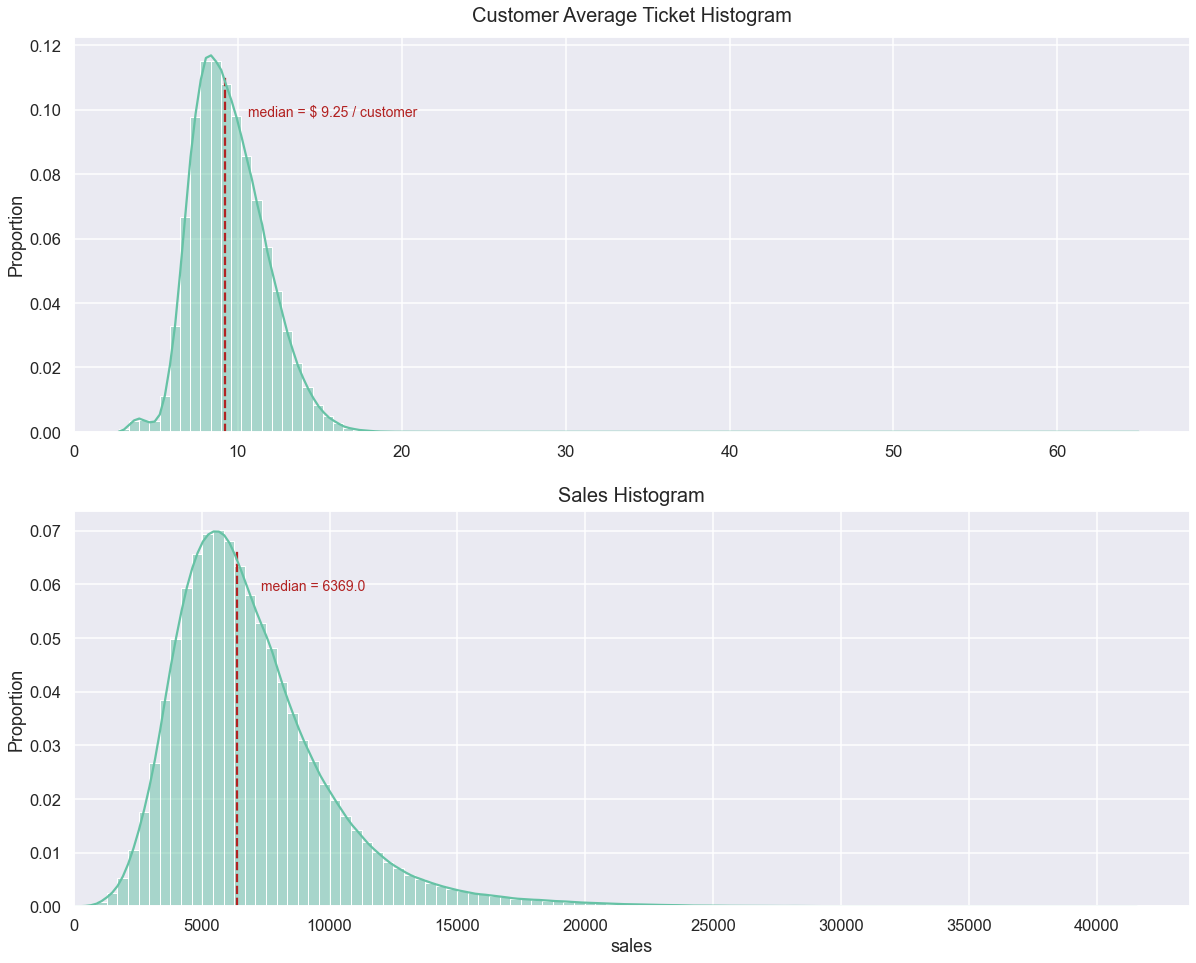

In [115]:
# histograms - customers_avg_ticket AND sales

plt.figure(figsize=(20, 16))

plt.subplot(2, 1, 1)
ax1 = sns.histplot(data=df4, x='customers_avg_ticket', stat='proportion', bins=100, kde=True)
ax1.set_title('Customer Average Ticket Histogram', fontsize=20, pad=15)
ax1.set_xlabel('')
ax1.set_xlim(left=0)
median1 = np.median(df4['customers_avg_ticket'])
_, y1_max = ax1.get_ylim()
ax1.vlines(x=median1, ymin=0, ymax=y1_max*0.9, linestyles='dashed', label='median', colors='firebrick')
ax1.annotate(f'median = $ {median1} / customer', xy=(median1*1.15, y1_max*0.8), fontsize=14, color='firebrick')


plt.subplot(2, 1, 2)
ax2 = sns.histplot(data=df4, x='sales', stat='proportion', bins=100, kde=True)
ax2.set_title('Sales Histogram', fontsize=20, pad=10)
ax2.set_xlim(left=0)
median2 = np.median(df4['sales'])
_, y2_max = ax2.get_ylim()
ax2.vlines(x=median2, ymin=0, ymax=y2_max*0.9, linestyles='dashed', label='median', colors='firebrick')
ax2.annotate(f'median = {median2}', xy=(median2*1.15, y2_max*0.8), fontsize=14, color='firebrick')

plt.show()

### <font color='#2365FF'> 4.1.3. Categorical Variable </font>

**STATE HOLIDAY**

In [119]:
df4.query("state_holiday != 'none'").value_counts(subset='state_holiday')

state_holiday
public       694
easter       145
christmas     71
dtype: int64

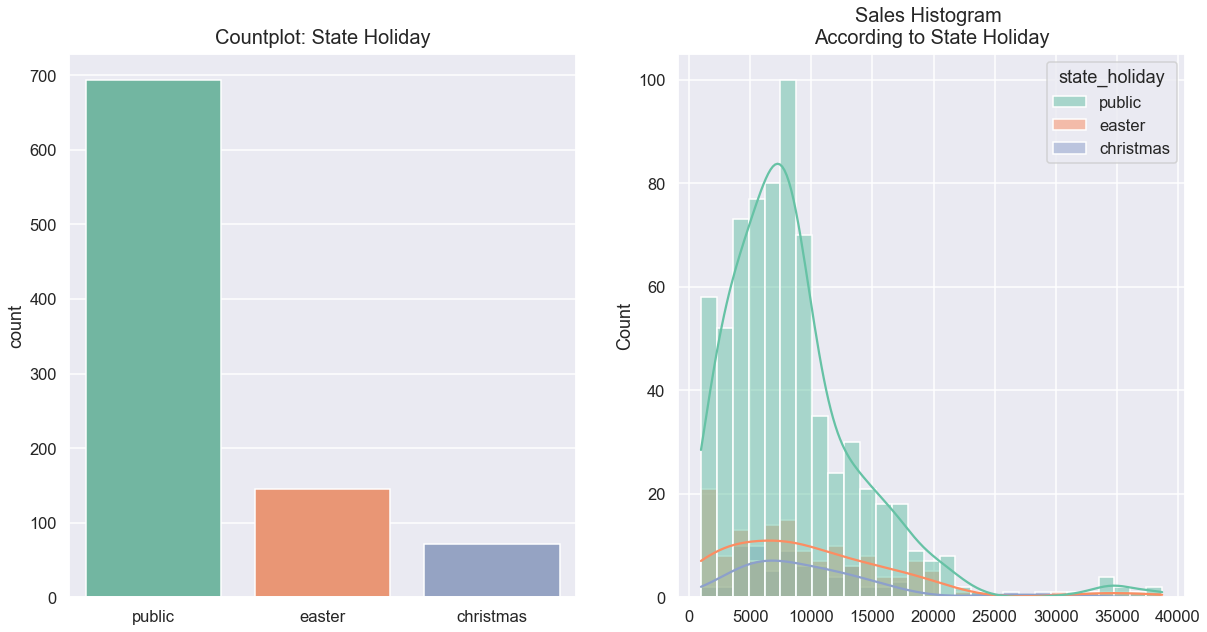

In [146]:
# state_holiday
# not considering regular day -> state_holiday == 'none'

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='state_holiday', data=df4.query("state_holiday != 'none'"))
# ax.figure.set_size_inches(10, 10)
ax1.set_title('Countplot: State Holiday', fontsize=20, pad=10)
ax1.set_xlabel('')

plt.subplot(1, 2, 2)
ax2 = sns.histplot(x='sales', data=df4.query("state_holiday != 'none'"), hue='state_holiday', kde=True)
ax2.set_title('Sales Histogram \nAccording to State Holiday', fontsize=20, pad=10)
ax2.set_xlabel('')

plt.show()

**STORE TYPES**

In [135]:
df4.value_counts(subset='store_type')

store_type
a    457042
d    258768
c    112968
b     15560
dtype: int64

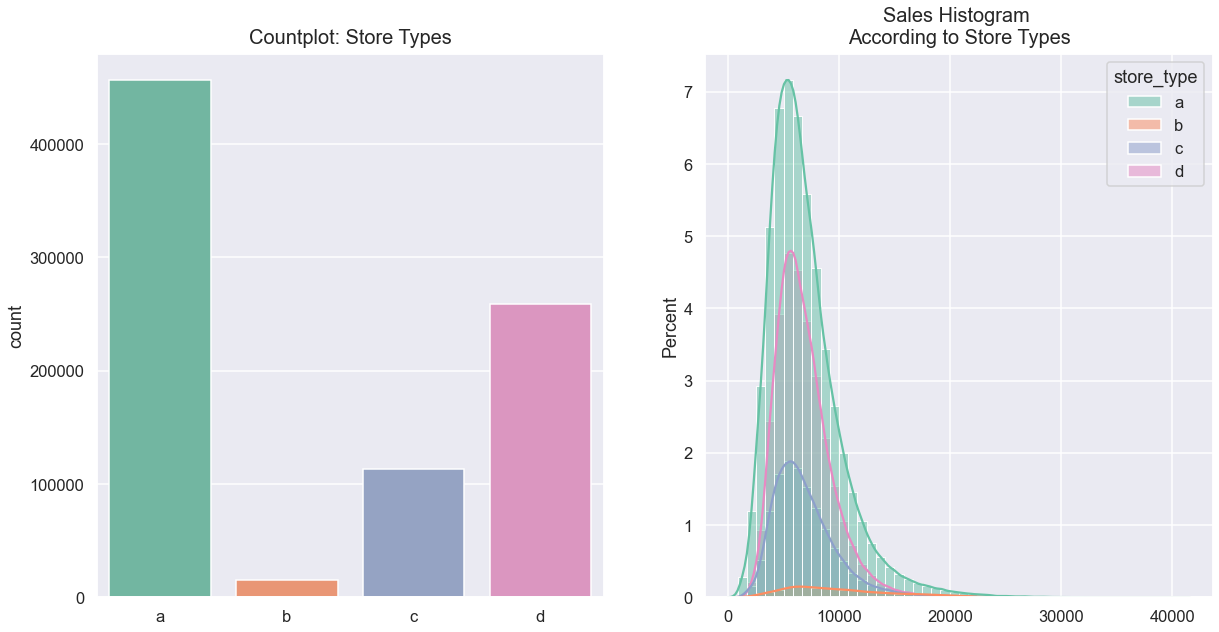

In [145]:
# store_type

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='store_type', data=df4, order=['a','b','c','d'])
# ax.figure.set_size_inches(10, 10)
ax1.set_title('Countplot: Store Types', fontsize=20, pad=10)
ax1.set_xlabel('')

plt.subplot(1, 2, 2)
ax2 = sns.histplot(x='sales', data=df4, hue='store_type', stat='percent', bins=50, hue_order=['a','b','c','d'], kde=True)
ax2.set_title('Sales Histogram \nAccording to Store Types', fontsize=20, pad=10)
ax2.set_xlabel('')

plt.show()

**ASSORTMENT**

In [148]:
df4['assortment'].value_counts()

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

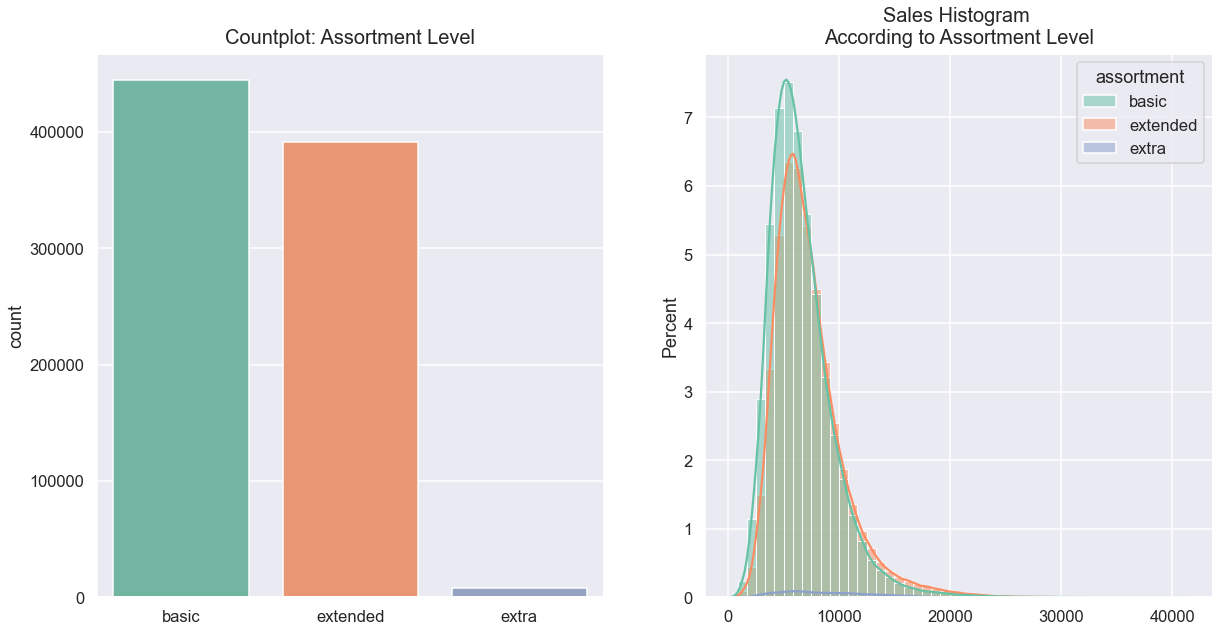

In [147]:
# assortment

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='assortment', data=df4, order=['basic','extended','extra'])
# ax.figure.set_size_inches(10, 10)
ax1.set_title('Countplot: Assortment Level', fontsize=20, pad=10)
ax1.set_xlabel('')

plt.subplot(1, 2, 2)
ax2 = sns.histplot(x='sales', data=df4, hue='assortment', stat='percent', bins=50, hue_order=['basic','extended','extra'], kde=True)
ax2.set_title('Sales Histogram \nAccording to Assortment Level', fontsize=20, pad=10)
ax2.set_xlabel('')

plt.show()

## <font color='#200CF'> 4.2. Bivariate Analysis </font>

## <font color='#200CF'> 4.3. Multivariate Analysis </font>